# TP 4 – Time Series in the Real World (Optional)

**Optional lab** (not counted in the final grade)

## Motivation

This lab aims to encourage you to use the whole tools from this course on a real time series. It is not an exam and it is not graded. You are free to:

- Choose data that you find interesting.
- Decide how far you want to go: from basic exploratory analysis to more advanced methods from Chapters 3 and 4.
- If you wish, you can also contrast the analysis with methods from other courses (e.g. classic machine learning or deep learning, Markov models or other tools from stochastic processes and control).
- Treat this as a small project you can later show (e.g. internship / research interviews).

Focus on **reviewing the course content**, **understanding the data** and **explaining your reasoning**.

## 1. Connection to the Lecture Notes

You are encouraged to apply concepts from different chapters of the lecture notes:

- **Chapter 2 – Weakly Stationary Processes**
  - Sample mean, autocovariance, autocorrelation.
  - Periodogram and spectral density.

- **Chapter 3 – Linear Models**
  - Linear filtering by absolutely summable coefficients.
  - MA(q), AR(p) and ARMA(p, q) processes.
  - Causal / invertible representations and the idea that many stationary processes can be seen as the output of a
    linear filter applied to white noise.

- **Chapter 4 – Linear Forecasting**
  - Linear prediction of a weakly stationary process.
  - Yule–Walker equations for AR(p) models.
  - Levinson–Durbin algorithm for solving the Yule–Walker system efficiently.
  - Innovations process and the innovations algorithm.
  - Wold decomposition: representing a process as a (possibly infinite) causal MA filter driven by white noise.

You are *not* required to implement all of these advanced methods.  
However, you are welcome to use them as far as you feel comfortable:

- For a moderate level, an AR(p) model with Yule–Walker is already enough (recall Lab3).
- For a more advanced level, you may experiment with ARMA(p, q), Levinson–Durbin, or the innovations algorithm.

## 2. Choice of Data

In this lab you will work with a univariate time series with regular time spacing (e.g. hourly, daily).  You can either use one of the provided datasets (A–C) or propose your own dataset (D).

---

### Option A – Electricity Load / Traffic Flow

Examples:
- Hourly electricity demand for a region or country.
- Hourly or 15-minute vehicle counts on a road segment.

Questions you might explore:
- What daily or weekly cycles are visible?
- Which frequencies dominate the spectrum?
- Can a simple AR/ARMA model give reasonable short-term forecasts?

---

### Option B – Weather Data (Temperature / Precipitation)

Examples:
- Daily temperature in a city over several years.
- Daily precipitation amounts.

Possible questions:
- What is the seasonal (annual) cycle?
- Is there a trend over the years?
- After removing trend and seasonality, does the remainder look weakly stationary?

---

### Option C – Financial Time Series (Returns)

Examples:
- Daily log-returns of a stock index or exchange rate.

Possible questions:
- How close are returns to white noise?
- Is there any short-lag autocorrelation?
- Do you detect meaningful peaks in the spectrum?

---

### Option D – Your Own Idea

You may propose another time series, for example:
- Sensor readings, network traffic, web request counts,
- Audio/music features, EEG/ECG signals, etc.

Before starting the analysis, briefly **describe the dataset** you use (source, variable, resolution, time span).

---

### Predefined Datasets for This Lab

You can work with one of the following three prepared dataset.

**Dataset A – PJM East hourly electricity load (2015)**  
This dataset contains one full year of hourly electricity demand from the PJM East interconnection in the United States.  
The series runs from 1 January 2015 00:00 to 31 December 2015 23:00, for a total of 8760 hourly observations.  
The column `PJME_MW` gives the system load in megawatts.  
This series is well suited to studying daily and weekly seasonality, spectral peaks, and short-term load forecasting with AR/ARMA models.

**Dataset B – Paris daily average temperature (2010–2014)**  
Daily average air temperature for Paris (Europe region) from 1 January 2010 to 31 December 2014 (1826 days).  
The column `AvgTemperature_F` reports the mean temperature.  
It exhibits an annual seasonal cycle and is appropriate for analysing trend and seasonality, checking weak stationarity after suitable transformations, and comparing time-domain and frequency-domain views.

**Dataset C – S&P 500 daily prices and log-returns (2010–2019)**  
Daily observations of the S&P 500 stock index (`^GSPC`) from 5 January 2010 to 31 December 2019.  
The column `Close` is the daily closing price, and `log_return` is the day-to-day log-return computed from the closing prices.  
It allows you to study how close financial returns are to white noise, to examine short-lag autocorrelation, and to contrast the behaviour of financial time series with that of electricity load or temperature data in both the time and frequency domains.

## 3. Data Loading (Example Data and Code)
Feel free to adapt this code to other data and formats.

Loaded series from PJME_2015_hourly_subset.csv
Number of observations: 8760
Datetime
2015-01-01 00:00:00    32802.0
2015-01-01 01:00:00    31647.0
2015-01-01 02:00:00    30755.0
2015-01-01 03:00:00    30189.0
2015-01-01 04:00:00    29890.0
Name: PJME_MW, dtype: float64


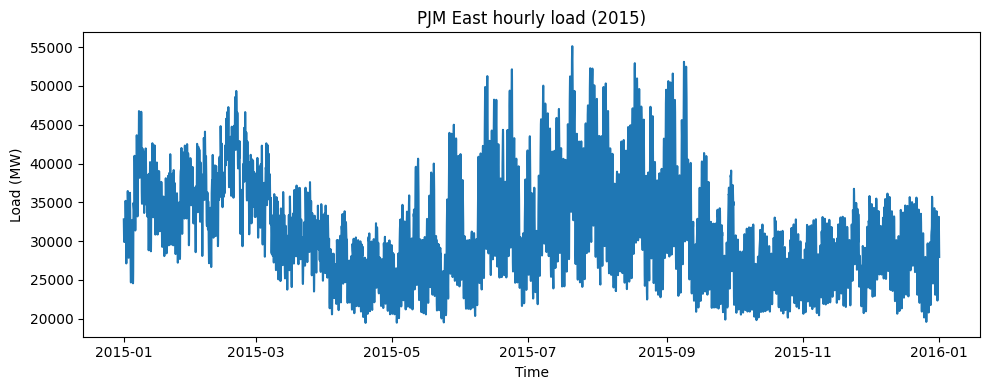

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Choose which dataset to use:
#   "A" the PJM hourly load (2015)
#   "B" the Paris daily temperature (2010–2014)
#   "C" the S&P 500 daily log-returns (2010–2019)

option = "A"   # change this to "B" or "C" as needed

if option == "A":
    file_path = "PJME_2015_hourly_subset.csv"
    date_col = "Datetime"
    value_col = "PJME_MW"
    title = "PJM East hourly load (2015)"
    ylabel = "Load (MW)"
elif option == "B":
    file_path = "ParisDailyTemp_2010_2014.csv"
    date_col = "Date"
    value_col = "AvgTemperature_F"
    title = "Paris daily average temperature (2010–2014)"
    ylabel = "Temperature (°F)"
elif option == "C":
    file_path = "SP500_2010_2019_logreturns.csv"
    date_col = "Date"
    value_col = "log_return"   # use "Close" to plot the price
    title = "S&P 500 daily log-returns (2010–2019)"
    ylabel = "Log-return"

# Load the selected dataset and create a time-indexed series
df = pd.read_csv(file_path, parse_dates=[date_col])
df = df.set_index(date_col).sort_index()

ts = df[value_col]

print(f"Loaded series from {file_path}")
print(f"Number of observations: {len(ts)}")
print(ts.head())

# Quick plot
plt.figure(figsize=(10, 4))
plt.plot(ts)
plt.title(title)
plt.xlabel("Time")
plt.ylabel(ylabel)
plt.tight_layout()
plt.show()

## 4. Time-Domain Exploration

Try to carry out the following as we did in previous labs:

1. **Visual inspection and data cleaning**
   - Inspect the plotted series.
   - Identify possible outliers, noise, missing values or data errors.
   - Comment on trend, seasonal patterns, or structural breaks.
   - Comment on whether additional preprocessing or transformations are needed.

2. **Stationarity discussion**
   - Discuss whether the series appears weakly stationary.
   - If not, consider simple transformations:
     - Differencing to remove deterministic trends.
     - Seasonal differencing (e.g. lag 24 for daily cycle in hourly data, lag 7 for weekly cycle in daily data).
   - Explain which transformation you chose and why.

3. **Autocovariance and autocorrelation**
   - Compute the empirical autocovariance and autocorrelation functions.
   - Interpret the main features of the ACF: persistence at small lags, periodic patterns, fast/slow decay, etc.

## 5. Spectrum Analysis

Apply the frequency-domain tools from the course:

1. **Periodogram / Spectral density estimate**
   - Compute and plot the periodogram (or a smoothed spectral estimate) of your (approximately) stationary series.
   - Identify any peaks in the spectrum.
   - Relate these peaks to real-world cycles (e.g. daily, weekly, yearly patterns).

2. **Connection with linear filters (Chapter 3)**
   - Recall that a stationary process can often be viewed as the output of a linear filter applied to white noise.
   - Based on the spectrum you observe, discuss informally what kind of filter your data might correspond to:
     - Low-pass (emphasizing slow variations / trend-like behavior)?
     - Band-pass (strong energy at specific frequencies)?
     - High-pass or something more complicated?
   - Explain how this viewpoint connects to MA(q) or ARMA(p, q) models.

## 6. Linear Modelling and Prediction (Chapters 3 & 4)

In this part you will model your time series using the linear models from Chapter 3 and the prediction framework
from Chapter 4.

### 6.1 Choosing a Model Class

- Use your ACF (and if you like, PACF) to decide between:
  - A pure AR(p) model.
  - A pure MA(q) model.
  - An ARMA(p, q) model.

Explain your choice.

### 6.2 Parameter Estimation

Depending on your ambition, you can:
  - Use Yule–Walker equations to estimate the parameters of an AR(p) model.
  - Use code and ideas from Lab 3 as a starting point.
  - Implement the Levinson–Durbin algorithm to solve the Yule–Walker system recursively and obtain both AR
    coefficients and prediction error variances.
  - Extend from AR(p) to ARMA(p, q) by using appropriate numerical routines or libraries.

Clearly state which approach you choose and justify the chosen order(s) p (and q, if relevant).

### 6.3 Linear Forecasting

Using your fitted model conduct:

1. **One-step-ahead prediction**
   - Express the linear predictor of $X_{t+1}$ in terms of past observations, as in Chapter 4.
   - If you use an AR(p) model, this corresponds to a weighted sum of the last p observations.

2. **Multi-step prediction**
   - Discuss (or implement) how to produce forecasts several steps ahead.
   - You may generate a forecast path over a test period and compare it with the observed values.

3. **Train/Test evaluation**
   - Split your time series into a training part and a test part (e.g. last 10% of observations as test set).
   - Fit the model on the training set.
   - Use the model to forecast the test set.
   - Compute simple error measures (MAE, RMSE) and comment on whether the performance is satisfactory for your
     application.

4. **Innovations viewpoint**
   - Relate your predictor to the innovations process introduced in Chapter 4.
   - Optionally, describe how the innovations algorithm could be used to build predictors directly from the
     covariance structure of the process.

## 7. Wold Decomposition and Interpretation
1. **Wold decomposition (Chapter 4)**
   - Recall that any purely nondeterministic weakly stationary process can be represented as
     a (possibly infinite-order) causal MA filter applied to a white noise sequence.
   - Discuss how your fitted AR or ARMA model approximates such a representation.

2. **Approximate MA(∞) representation**
   - For an AR(p) model, describe qualitatively how it corresponds to an MA(∞) representation.
   - Connect this idea with the spectral factorization viewpoint: the spectrum of your process can be written in
     terms of the transfer function of a causal filter.

3. **Deterministic vs. stochastic components**
   - From your analysis (trend, seasonality, residuals), discuss what part of your series is "deterministic"
     (predictable by a known pattern) and what part is stochastic (innovation-like noise).